# 付録1：乱数の話

自然界にランダムな事象はたくさんあるが，計算機上で「きちんとした」乱数を作るのは実は簡単ではない．プログラムによって生成している以上，生成される数列は確定的なものになってしまう．このような数列を**擬似乱数列**と呼ぶ．計算機上で乱数を扱うときは，その乱数がどのぐらい「きちんとしているか」を気にしておく必要がある．特に暗号の分野では乱数の性質によっては簡単に解読されてしまうため，熱雑音など自然界のランダム性を取り込むハードウェアを使うこともある．

## 線形合同法

擬似乱数生成の古典的手法の代表が**線形合同法**である．より古くは2乗中抜き法 (平方採中法) などもある．線形合同法は漸化式
$$X_{n+1} = \left(A\times X_n + B\right)\mod M$$
で与えられる．ただし $M>A$，$M>B$，$A>0$，$B\ge 0$ であり，$B=0$の場合を乗算合同法と呼ぶこともある．

$X_0$ を乱数の種と呼ぶ．$X_n$だけから$X_{n+1}$が決まるので，同じ数がでてきたらその後は同じ数列が繰り返されることになる．この数列の長さを周期と言い，長い方が好ましい．

In [133]:
# 乱数の種
r_seed = 0
# 定数
A = 3
B = 51
M = 127
# 数列長
n_max = 150

period = 0

x = r_seed
x_1 = (A * x + B) % M
for i in range(n_max):
    print("{} ".format(x), end="")
    if x == x_1 and period <= 1:
        period = i - 1

    x = (A * x + B) % M
        
print("\nperiod = {}".format(period))

0 51 77 28 8 75 22 117 21 114 12 87 58 98 91 70 7 72 13 90 67 125 45 59 101 100 97 88 61 107 118 24 123 39 41 47 65 119 27 5 66 122 36 32 20 111 3 60 104 109 124 42 50 74 19 108 121 33 23 120 30 14 93 76 25 126 48 68 1 54 86 55 89 64 116 18 105 112 6 69 4 63 113 9 78 31 17 102 103 106 115 15 96 85 52 80 37 35 29 11 84 49 71 10 81 40 44 56 92 73 16 99 94 79 34 26 2 57 95 82 43 53 83 46 62 110 0 51 77 28 8 75 22 117 21 114 12 87 58 98 91 70 7 72 13 90 67 125 45 59 
period = 126


線形合同法による乱数列は定数の組み合わせに強く左右される．
- 周期の最大は $M$ になる．例えば $(A, B, M)=(7, 5, 27)$．
- 設定によっては周期は短くなる．例えば $(A, B, M) = (7, 5, 28)$．
- 乱数の種は1回しか出てこない場合もある．例えば$(A, B, M) = (7, 5, 21)$．また，$(A, B, M)=(8, 5, 32)$ では3つ目からずっと同じ数字が出続ける．
- 最下位ビットが特定のパターンに陥りやすい．特に，$M$を偶数にした場合は必ず単純なパターンに陥る．例えば $(A, B, M) = (7, 6, 26)$ では偶数しか出ない．$(A, B, M)=(8, 5, 28)$では奇数しか出ない．$(A, B, M) = (7, 5, 26)$ では偶数と奇数が交互に出る．

***下位kビットを見ると周期は高々$2^k$になる．← 本当か？***

なお周期が最大 ($M$) になる条件は分かっており
- $B$と$M$が互いに素
- $A-1$ が，$M$の素因数全てで割り切れる
- $M$ が4の倍数である場合は，$A-1$も4の倍数である

を満たせばよい．$B=0$ の場合は0が出た時点でその後はずっと0しか出ないため，$B=0$ では最大の周期は $M-1$ である．

適切な定数の組み合わせにはいくつかあり，有名なものは Park & Miller の $(A, B, M) = (48,271, 0, 2^{31}-1)$ など．独自に決める場合は，下位ビットの規則性を回避するために下位数ビットを切り捨てるなどの処置をすることが多い．

この線形合同法の弱点に関連するちょっとしたエピソードとして，2006年に発売されたとあるコンピュータゲームで，「サイコロが必ず奇数と偶数を交互に出す」という現象があった．上の説明の通り，線形合同法で最下位ビットは規則的な出力になるため，このゲームは線形合同法の既知の問題を潰さずに実装したのではないか，と言われた (別のバグが原因との説もあり，真相は不明)．

また，もう一つの弱点として多次元で分布が規則的になるという性質がある．$(A,B,M)=(3,51,127)$は周期126の乱数を生成するが，
生成された乱数列を $(x_0, x_1)$，$(x_2, x_3)$，$(x_4, x_5)$ ... のように組にしてプロットしてみると，下のようになる．明らかに規則性が見てとれるため，線形合同法の乱数を多次元で使うことはできない．


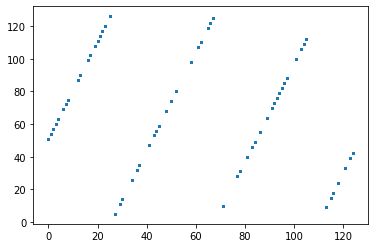

In [135]:
# 種
r_seed = 19
# 定数 from Park & Miller
A = 3
B = 51
M = 127
# 点数
n_max = 10000

from matplotlib import pyplot

x = []
y = []
r = r_seed
for i in range(n_max):
    x.append(r)
    r = (A * r+B) % M
    y.append(r)
    r = (A * r+B) % M
    
pyplot.scatter(x,y, s=1)
pyplot.show()

## 線形帰還シフトレジスタ (LFSR)

線形合同法よりもよい乱数を得る方法が線形帰還シフトレジスタである．回路設計の人にとってはLFSRよりも**PRBS** (Psudo-Random Bit Sequence，擬似ランダムビット列)と言った方がなじみが深いかも知れない．アイパターンやビットエラーレートを求めるときに使うPRBSである．シフトレジスタとXORだけで実装可能という利点がある．

LFSRはシフトレジスタからいくつかのビットを取り出し，それらのXORを取って入力に戻すことで実現する．入力に戻すビットをタップと呼び，タップ位置のリストをタップシーケンスと呼ぶ．LFSRではタップシーケンスの選び方によって生成される乱数列の周期が変わる．なお全ビットが0になるとその後は0しか出て来ないため，最大周期はシフトレジスタのビット長さ$N$に対して$2^N-1$となる．


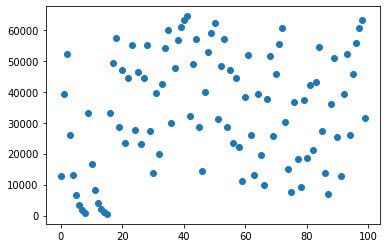

In [101]:
# シフトレジスタのビット数
bits = 16
# タップシーケンス (左端が1)
taps = [11,13,14,16]
msb = taps.pop(-1)
# 種 (ランダム)
import numpy
sr = numpy.random.randint(0,2,16).tolist()
# 出力長
n_max = 100

y = []

for i in range(n_max):
  #    print(int("".join(map(str,sr)), 2))
    y.append(int("".join(map(str,sr)), 2))
    fb = sr[msb - 1]
    for t in taps:
        fb = fb ^ sr[t-1]
    sr.pop(-1)
    sr.insert(0, fb)

pyplot.scatter(range(n_max), y)
pyplot.show()

値はランダムに散らばっているように見えるが，一部に0もしくは最大値に向かって単調に減少/増加する部分が見える．これが線形フィードバックシフトレジスタ全般の弱点で，レジスタの値で0または1が極端に多くなった場合に変化が単調になる．種の値を1か0で埋めつくした場合に出力される値と，レジスタ中の0の個数をプロットすると，以下のようになる．

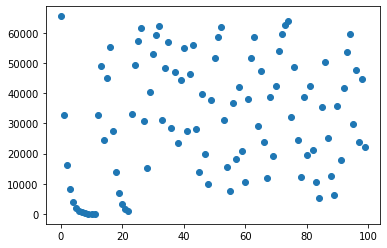

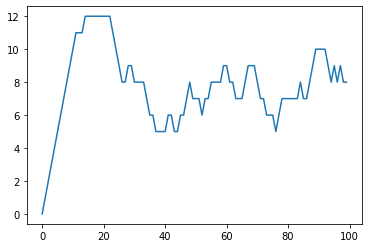

In [112]:
# シフトレジスタのビット数
bits = 16
# タップシーケンス (左端が1)
taps = [11,13,14,16]
msb = taps.pop(-1)
# 種
# (全部1)
sr = [1] * bits
# (左端以左外0)
#sr = [0] * bits
#sr[0] = 1

# 出力長
n_max = 100

y = []
y2 = []

for i in range(n_max):
    y.append(int("".join(map(str,sr)), 2))
    y2.append(sr.count(0))
    fb = sr[msb - 1]
    for t in taps:
        fb = fb ^ sr[t-1]
    sr.pop(-1)
    sr.insert(0, fb)
    
pyplot.scatter(range(n_max), y)
pyplot.show()
pyplot.plot(range(n_max), y2)
pyplot.show()

1で埋めた場合は0の個数が単調に増加し，0が多い場合はしばらく0の個数が一定で，その後単調に下がることが分かる．

これは少数のタップで左端のレジスタを更新するため，一度同じ値で埋めつくされてしまうと変化が全てのレジスタに行き渡るのに時間がかかるためである．特に0が多数を占める場合にはフィードバックされる値も0になり，しばらく零超過状態が続く．これは後述のメルセンヌツイスタにも共通する問題で，種の生成に注意しなければならない．(メルセンヌツイスタの種は19936ビットあるので，変な種を使ってしまうと超過状態からの脱出にはすごく時間がかかる．)

## Pythonのrandom() — メルセンヌツイスタ

これまで使ってきた Python の `random()` は大丈夫なのだろうか？ Python の `random()` は比較的新しい手法である**メルセンヌツイスタ**を使っているので，安心して使ってよい．周期は$2^{19937}-1$という長さである．ちなみに$2^{19937}-1$は24番目のメルセンヌ素数で，だいたい$4.3\times 10^{6002}$ぐらい．線形合同法にあったような多次元での規則性も623次元まで問題ない．その他統計的性質も真の乱数に近く，すべての diehard tests をクリアする．(ただし暗号に使うのはマズい．)

xorshift

一方で，真にランダムな乱数は人間の主観的には偏って見える，という研究もある．

http://www.jaist.ac.jp/is/labs/ikeda-lab/rs_randomgeneration.html
http://blog.livedoor.jp/lunarmodule7/archives/4523745.html